# Example 2 - Topography

This example introduces methods for importing and using a DEM to create the model domain. 

Instead of imposing a mesh structure on a rectangular grid, this example uses a mesh generator to build mesh structures inside a polygon set by the user. The mesh resolution (the maximum area of a triangle used for triangulation) and the boundary tags are also set during the creation of the domain.

It is also possible to use this technique to specify areas of increased resolution defined by multiple interior polygons, each with a specified resolution. The user can also specify one or more ’holes’ – that is, areas bounded by polygons in which no triangulation is required.

The DEM shows a short reach of the lower Rio Puerco, NM:
https://goo.gl/maps/7UHQXU9kPKB2

In [9]:
################################################################################################
# Import ANUGA
################################################################################################

import sys
default_stdout = sys.stdout
default_stderr = sys.stderr

import anuga

reload(sys)
sys.stdout = default_stdout
sys.stderr = default_stderr



################################################################################################
# Convert elevation raster from ASCII to PTS file
################################################################################################

filename_root = 'data/raster'

anuga.asc2dem(filename_root + '.asc', use_cache = False, verbose = True)
anuga.dem2pts(filename_root + '.dem', use_cache = False, verbose = True)





################################################################################################
# Import boundary polygon (CSV of node UTM coordinates) and set boundary tags
################################################################################################

bounding_polygon = anuga.read_polygon('data/outline.csv')

boundary_tags = {'side':[0,1,2,4],
                   'top':[3],
                'bottom':[5]}


inner_polygon = anuga.read_polygon('data/inner_polygon.csv')



################################################################################################
# Create the computational domain
################################################################################################

domain = anuga.create_domain_from_regions(bounding_polygon = bounding_polygon,
                                          boundary_tags = boundary_tags,
                                          maximum_triangle_area = 200,
                                          mesh_filename = filename_root + '.msh',
                                         interior_regions = [[inner_polygon, 100]])






################################################################################################
# Set initial conditions
################################################################################################

domain.set_quantity('elevation', 
                    filename = filename_root + '.pts')

domain.set_quantity('stage', expression='elevation')   # Dry initial condition






################################################################################################
# Set other domain options
################################################################################################

domain.set_name('topo')     # Specify output file name


domain.set_quantities_to_be_stored({'elevation': 1,
                                    'stage': 2,
                                    'xmomentum': 2,
                                    'ymomentum': 2})




################################################################################################
# Set boundary conditions
################################################################################################

# use vertex values of quantity 'elevation' in computational domain
# to find minimum bed elevation for outlet
min_elev = domain.quantities['elevation'].vertex_values.min()

Bd = anuga.Dirichlet_boundary([1528., 0., -4.])         # inlet
Bo = anuga.Dirichlet_boundary([min_elev - 1, 0., 0.]) # outlet
Br = anuga.Reflective_boundary(domain)                # walls

domain.set_boundary({'side':Br,   # wall
                      'top':Bd,   # inlet
                   'bottom':Bo})  # outlet





################################################################################################
# Evolve the domain
################################################################################################

import numpy as np
rainfall = 0.005

for t in domain.evolve(yieldstep = 50, finaltime = 3000.0):
    
#     stage = domain.quantities['stage'].centroid_values
    
#     stage = stage + rainfall * 50 
#     domain.set_quantity('stage', stage)
    
    domain.print_timestepping_statistics()

    
    

Reading METADATA from data/raster.prj
Reading DEM from data/raster.asc
Got 292 lines
Store to NetCDF file data/raster.dem
Reading DEM from data/raster.dem
Store to NetCDF file data/raster.pts
There are 80652 values in the elevation
There are 80652 values in the clipped elevation
There are 37882 NODATA_values in the clipped elevation
Generating mesh to file 'data/raster.msh'
Domain: Initialising
Pmesh_to_Domain: Initialising
Pmesh_to_Domain: Done
General_mesh: Building basic mesh structure
General_mesh: Computing areas, normals, edgelengths, centroids and radii
General Mesh: Building inverted triangle structure
Mesh: Initialising
Mesh: Building neigbour structure
Mesh: Building surrogate neigbour structure
Mesh: Building boundary dictionary
Mesh: Building tagged elements dictionary
Mesh: Done
Domain: Expose mesh attributes
Domain: Expose quantity names and types
Domain: Build Quantities
Domain: Set up communication buffers 
Domain: Set up triangle/node full flags 
Domain: Set defaults
D

AssertionError: 

In [2]:
from netCDF4 import Dataset
import numpy as np

swwFile = 'topo.sww'  # name of output file
fid = Dataset(swwFile, mode='r')

x = fid.variables['x'][:]
y = fid.variables['y'][:]
elev = fid.variables['elevation'][:]
stage = fid.variables['stage'][:]

depth = stage - elev


# Use a flux limiter to prevent too-high velocities at small depths

xmom = fid.variables['xmomentum'][:]
xvel = (xmom * depth) / (depth**2 + 0.0001)

ymom = fid.variables['ymomentum'][:]
yvel = (ymom * depth) / (depth**2 + 0.0001)


fid.close()


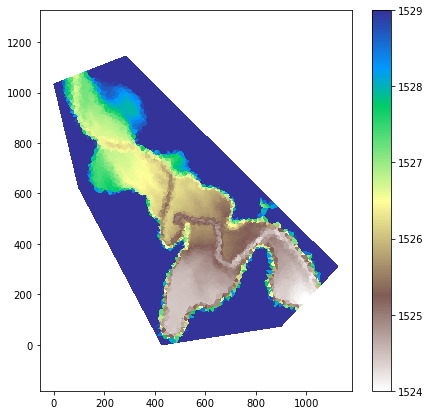

In [3]:
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
# IPython magic command to create figures within the notebook
%matplotlib inline

triang = mtri.Triangulation(x, y)

plt.figure(figsize=(7,7))
plt.tripcolor(triang, elev, cmap='terrain_r', vmax = 1529)
plt.colorbar()
plt.axis('equal');

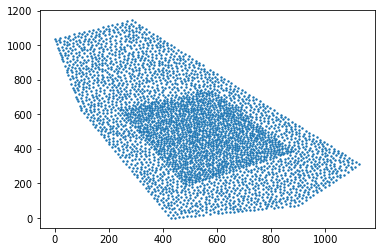

In [4]:
plt.scatter(x,y, s=2)

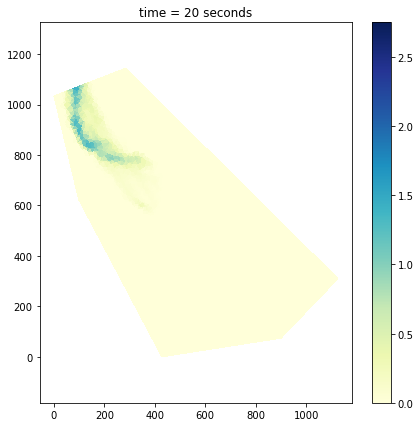

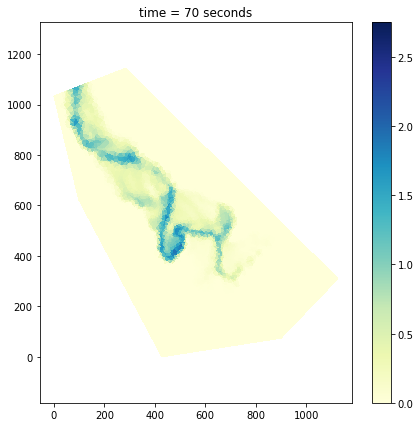

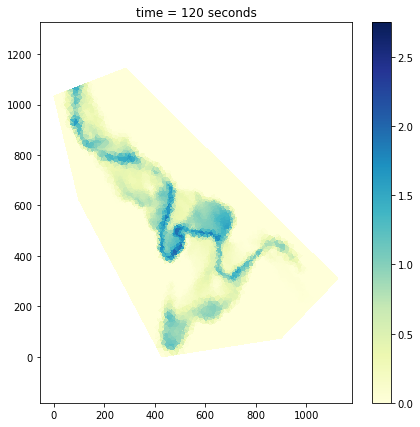

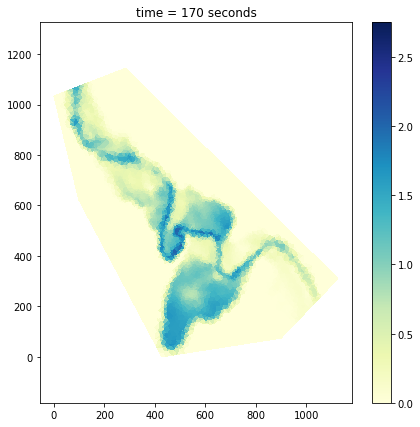

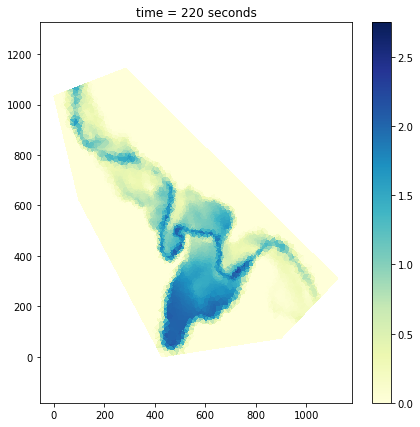

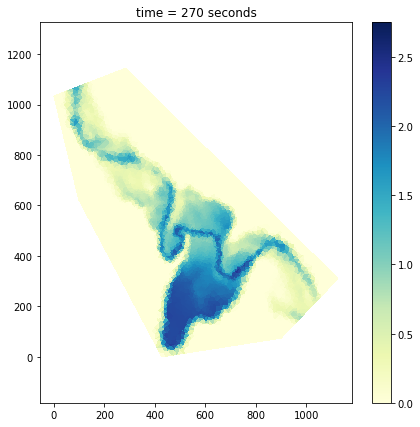

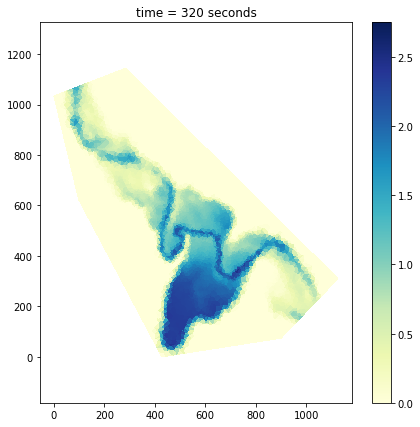

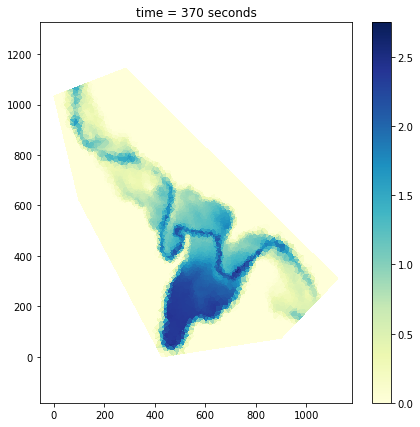

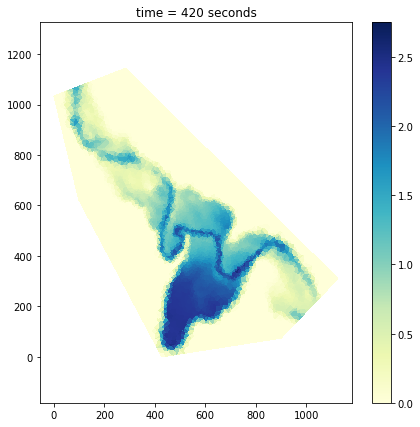

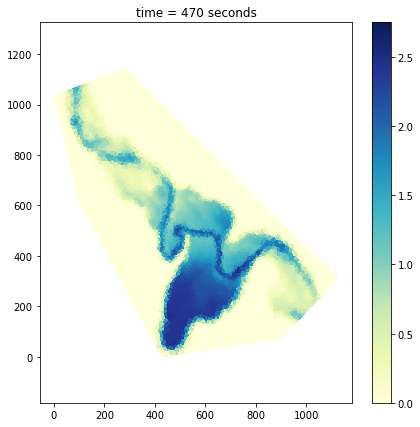

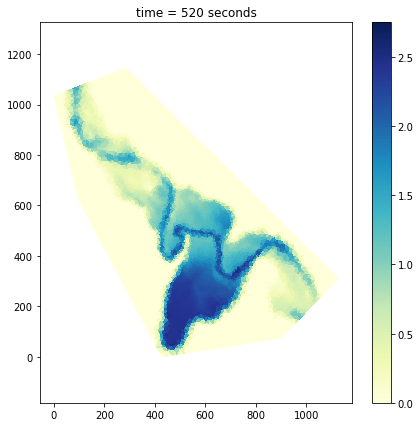

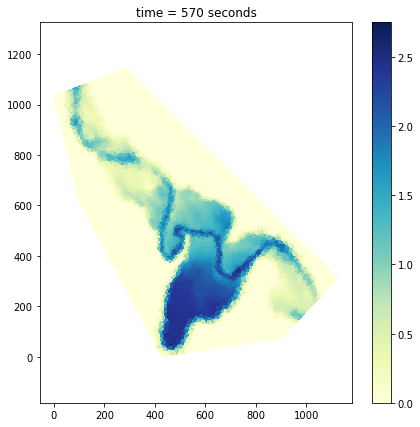

In [5]:
for t in range(2, len(depth), 5):
    
    plt.figure(figsize=(7,7))
    
    plt.tripcolor(triang, depth[t], cmap='YlGnBu', vmin = 0, vmax = depth.max())
    
    plt.title('time = ' + str(t * 10) + ' seconds')
    plt.colorbar()
    plt.axis('equal');
    plt.show()

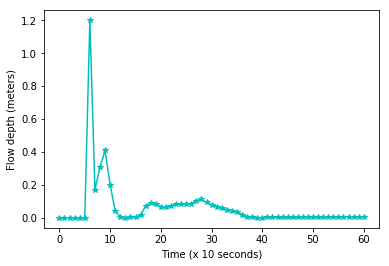

In [8]:
################################################################################################
# Hydrograph
################################################################################################

# Select a value of y for a "flow gage"
# Specifying a cross-section is easier than a point
gage = 600

hydrograph = np.zeros((len(depth),))

# For every timestep, get the maximum value of depth within
# a 20 meter wide band (in N-S direction) around the "gage"
for t in range(len(depth)):
    hydrograph[t] = yvel[t][(y > gage - 10) & (y < gage + 10)].max()
    
plt.plot(hydrograph, 'c*-')
plt.ylabel('Flow depth (meters)')
plt.xlabel('Time (x 10 seconds)')